In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')

In [3]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  load_matrix('data/%s_matrix_L9.csv.gz' % dataset)[::9, :]

In [4]:
sample_matrices['cov'] = load_matrix('../globalmaxent/data/model_matrix.csv.gz')[::9, :]

In [5]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

In [6]:
fi = observables_dict['fi']['train'].mean(axis=0)
sample_matrices['independent'] = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape, p=fi)

In [7]:
sample_matrices['flat'] = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape)

In [32]:
nsample = 1e8
L = sample_matrices['test'].shape[1]
hists_dict = {}
for dataset in ['test', 'model', 'independent', 'flat', 'cov']:
    hists_dict[dataset] = pairwise_distances_jit(sample_matrices[dataset], N=nsample)

In [10]:
filtered = kmers_to_matrix(to_kmers(pd.read_csv('../pfam/data/human_downsampled.csv')['Sequence'], 9))[::9]

In [11]:
hists_dict['filtered'] = pairwise_distances_jit(filtered, N=nsample)

In [33]:
hists_dict['train_test'] = pairwise_distances_jit(sample_matrices['train'],
                                                  data2=sample_matrices['test'],
                                                  N=nsample)

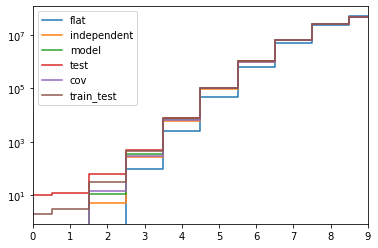

In [21]:
bins = np.arange(L+1)
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'test', 'cov', 'train_test']:
    ax.step(bins, hists_dict[dataset], label=dataset, where='mid')
ax.set_yscale('log')
ax.set_xticks(bins)
ax.set_xlim(bins[0], bins[-1])
ax.legend(loc='upper left');

In [13]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']
ps = aa_human
blocklength = sample_matrices['test'].shape[0]//len(ps)
sampless = []
for p in ps:
    samples = np.random.choice(np.arange(0, 20, 1),
                               size=(blocklength, sample_matrices['test'].shape[1]),
                               p=p)
    sampless.append(samples)
sample_composition = np.concatenate(sampless)

In [14]:
hists_dict['composition'] = pairwise_distances_jit(sample_composition, N=nsample)

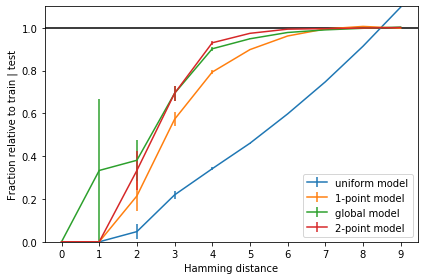

In [43]:
fig, ax = plt.subplots()
labels = {'flat': 'uniform model',
          'model': '2-point model',
          'cov':'global model',
          'independent' : '1-point model'}
for dataset in ['flat', 'independent', 'cov', 'model']:
    ax.errorbar(bins, (hists_dict[dataset])/(hists_dict['train_test']),
                hists_dict[dataset]**.5/hists_dict['train_test'],
                label=labels[dataset])
ax.set_xticks(bins)
ax.axhline(1.0, c='k')
ax.set_ylim(0.0, 1.1)
ax.legend(loc='lower right')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('Fraction relative to train | test')
fig.tight_layout()

In [39]:
pairwise_hist = {}
for dataset in ['model', 'independent', 'flat', 'cov']:
    pairwise_hist[dataset] = pairwise_distances_jit(sample_matrices[dataset],
                                   data2=sample_matrices['test'],
                                   N=nsample)

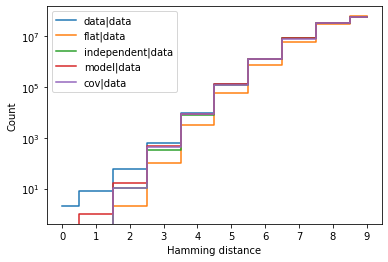

In [40]:
fig, ax = plt.subplots()
ax.step(bins, hists_dict['test'], where='mid', label='data|data')
for dataset in ['flat', 'independent', 'model', 'cov']:
    ax.step(bins, pairwise_hist[dataset], where='mid', label=dataset + '|data')
ax.set_yscale('log')
ax.set_xticks(bins);
ax.legend(loc='upper left')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('Count');

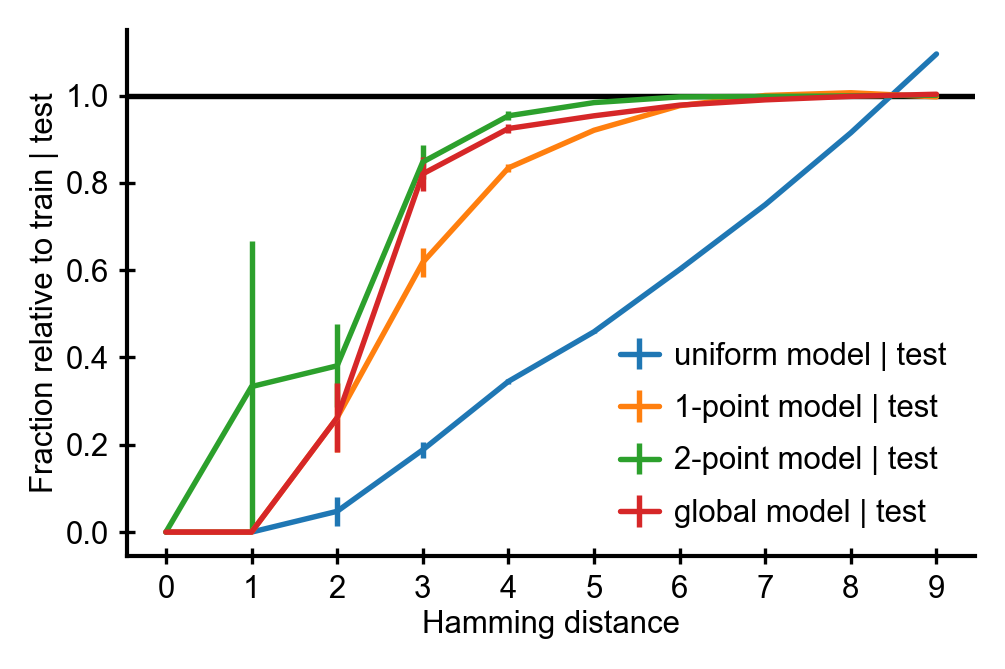

In [48]:
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'cov']:
    ax.errorbar(bins, pairwise_hist[dataset]/hists_dict['train_test'],
                pairwise_hist[dataset]**.5/hists_dict['train_test'],
                label=labels[dataset] + ' | test')
ax.set_xticks(bins)
ax.legend(loc='lower right')
ax.axhline(1.0, c='k')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('Fraction relative to train | test')
fig.tight_layout()
fig.savefig('../../paper/images/hammingdist.pdf')